In [155]:
import numpy as np
import random 
import matplotlib.pyplot as plt

In [2]:
def meshgrid(offset=[10,10]):
        '''
        生成类似于
        ((-2,-2),(-2,-1),(-2,0),(-2,1),(-2,2),
        (-1,-2),(-1,-1),(-1,0),(-1,1),(-1,2),
        (0,-2),(0,-1),(0,1),(0,2),
        (1,-2),(1,-1),(1,0),(1,1),(1,2),
        (2,-2),(2,-1),(2,0),(2,1),(2,2))
        这样的矩阵
        '''
        x_offset,y_offset = offset
        tmp = []
        for x in range(-x_offset,x_offset):
            for y in range(-y_offset,y_offset):
                tmp.append([x,y])
        tmp.pop(int(0.5*2*x_offset*2*y_offset+y_offset)) # 刨除(0,0)点

        return tmp

In [6]:
dir = meshgrid()
dir

[[-10, -10],
 [-10, -9],
 [-10, -8],
 [-10, -7],
 [-10, -6],
 [-10, -5],
 [-10, -4],
 [-10, -3],
 [-10, -2],
 [-10, -1],
 [-10, 0],
 [-10, 1],
 [-10, 2],
 [-10, 3],
 [-10, 4],
 [-10, 5],
 [-10, 6],
 [-10, 7],
 [-10, 8],
 [-10, 9],
 [-9, -10],
 [-9, -9],
 [-9, -8],
 [-9, -7],
 [-9, -6],
 [-9, -5],
 [-9, -4],
 [-9, -3],
 [-9, -2],
 [-9, -1],
 [-9, 0],
 [-9, 1],
 [-9, 2],
 [-9, 3],
 [-9, 4],
 [-9, 5],
 [-9, 6],
 [-9, 7],
 [-9, 8],
 [-9, 9],
 [-8, -10],
 [-8, -9],
 [-8, -8],
 [-8, -7],
 [-8, -6],
 [-8, -5],
 [-8, -4],
 [-8, -3],
 [-8, -2],
 [-8, -1],
 [-8, 0],
 [-8, 1],
 [-8, 2],
 [-8, 3],
 [-8, 4],
 [-8, 5],
 [-8, 6],
 [-8, 7],
 [-8, 8],
 [-8, 9],
 [-7, -10],
 [-7, -9],
 [-7, -8],
 [-7, -7],
 [-7, -6],
 [-7, -5],
 [-7, -4],
 [-7, -3],
 [-7, -2],
 [-7, -1],
 [-7, 0],
 [-7, 1],
 [-7, 2],
 [-7, 3],
 [-7, 4],
 [-7, 5],
 [-7, 6],
 [-7, 7],
 [-7, 8],
 [-7, 9],
 [-6, -10],
 [-6, -9],
 [-6, -8],
 [-6, -7],
 [-6, -6],
 [-6, -5],
 [-6, -4],
 [-6, -3],
 [-6, -2],
 [-6, -1],
 [-6, 0],
 [-6, 1],
 [-6,

In [37]:
offset = [20,18]
x_offset,y_offset = offset
tmp = []
for x in range(-x_offset,x_offset):
    for y in range(-y_offset,y_offset):
        tmp.append([x,y])

In [59]:
r_work = [random.uniform(.005*0.8,.005*1.2) for _ in range(10)]

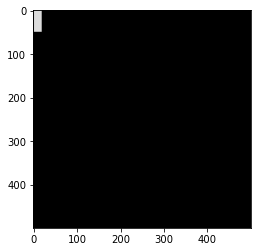

In [182]:
# a = np.round(np.random.rand(50,50)*255)
new_figure = np.zeros((500,500,3),dtype=int)
new_figure[1,2:20,:] = [220,220,220]
plt.imshow(new_figure)

In [183]:
a = {1:23,45:56757}
list(a.keys())

[1, 45]

In [185]:
import numpy as np
from bqplot import Graph, LinearScale, ColorScale, Figure, Tooltip
from ipywidgets import Layout

fig_layout = Layout(width='600px', height='600px')

node_data = [
    dict(label='A', shape='rect'),
    dict(label='B', shape='ellipse'),
    dict(label='C', shape='ellipse'),
    dict(label='D', shape='rect'),
    dict(label='E', shape='ellipse'),
    dict(label='F', shape='circle'),
    dict(label='G', shape='ellipse'),
]
link_data = [{'source': s, 'target': t} for s, t in np.random.randint(0, 7, (10, 2)) if s != t]
graph = Graph(node_data=node_data, link_data=link_data, charge=-600, colors=['lightblue'] * 7)
graph.link_type = 'arc' # arc, line, slant_line
Figure(marks=[graph], layout=fig_layout)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='600px', width='600…